The goal of this notebook is to explore the strength of word-associations when using keywords to predict SDGs.

The primary measure will be TP vs FP since we are looking for the presence of SDGs. This will give an idea of how
different keywords perform in identifying different SDGs, where they do well and where they fail.


In [1]:
import pandas as pd
from variables import PREDICTIONS_TEMPLATE, GET_PREDICTION_DETAILS
from glob import glob
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import widgets
import seaborn as sns

In [2]:
model_name = "uoft_dict_approach"
project_of_interest = "2023_all_ugrad_outlines"


PATH = PREDICTIONS_TEMPLATE(model_name=model_name)

In [3]:
def get_unique_tpfp(counts):
    for kw1 in counts:
        for kw2 in counts:
            if kw1 == kw2:
                continue

            counts[kw2]["TP_unique"] -= counts[kw1]["TP_indicies"]
            counts[kw2]["FP_unique"] -= counts[kw1]["FP_indicies"]
    return counts


def count_keyword_TPFP(data):
    """
    Looks at "comparison" == TP or FP then looks
    into metadata['keyword_matches'] to identify which
    keywords were used to make those predictions.
    """

    counts = defaultdict(
        lambda: {
            "TP": 0,
            "FP": 0,
            "TP_indicies": set(),
            "FP_indicies": set(),
            "TP_unique": set(),
            "FP_unique": set(),
        }
    )
    total_tp = data[data["comparison"] == "TP"].shape[0]
    total_fp = data[data["comparison"] == "FP"].shape[0]
    total_fn = data[data["comparison"] == "FN"].shape[0]

    for i, row in data.iterrows():
        comparison = row["comparison"]

        if comparison not in ["TP", "FP"]:
            continue

        for keyword in set(row["prediction"]["metadata"]["keyword_matches"]):
            counts[keyword][comparison] += 1
            counts[keyword][f"{comparison}_indicies"].add(i)
            counts[keyword][f"{comparison}_unique"].add(i)

    for keyword, comparison_counts in counts.items():
        counts[keyword]["TP_total"] = total_tp
        counts[keyword]["FP_total"] = total_fp
        counts[keyword]["TP_proportion"] = (
            counts[keyword]["TP"] / total_tp if total_tp > 0 else None
        )
        counts[keyword]["FP_proportion"] = (
            counts[keyword]["FP"] / total_fp if total_fp > 0 else None
        )

        counts[keyword]["recall"] = (
            counts[keyword]["TP"] / (total_tp + total_fn)
            if total_tp + total_fn > 0
            else None
        )
        counts[keyword]["precision_all"] = counts[keyword]["TP"] / (total_tp + total_fp)
        counts[keyword]["precision_kw"] = counts[keyword]["TP"] / (
            counts[keyword]["TP"] + counts[keyword]["FP"]
        )

    return counts

In [4]:
# def main():
all_counts = []

for path in glob(PATH):
    filename = os.path.basename(path)

    sdg, model_name, project_name, datatype = GET_PREDICTION_DETAILS(filename)
    if project_name != project_of_interest:
        continue

    data = pd.read_json(path, lines=True)

    counts = count_keyword_TPFP(data)
    counts = get_unique_tpfp(counts)
    for keyword, comparison in counts.items():
        all_counts.append(
            dict(
                sdg=sdg,
                model_name=model_name,
                project_name=project_name,
                datatype=datatype,
                keyword=keyword,
                **comparison
            )
        )

df = pd.DataFrame(all_counts)
df["keyword_performance"] = df["TP_proportion"] / df["FP_proportion"]
df["FP_proportion"] = df["FP_proportion"].apply(lambda x: -x)
df["TP_unique_count"] = df["TP_unique"].apply(len)
df["FP_unique_count"] = df["FP_unique"].apply(len)
groupbycols = ["sdg", "model_name", "project_name", "datatype"]

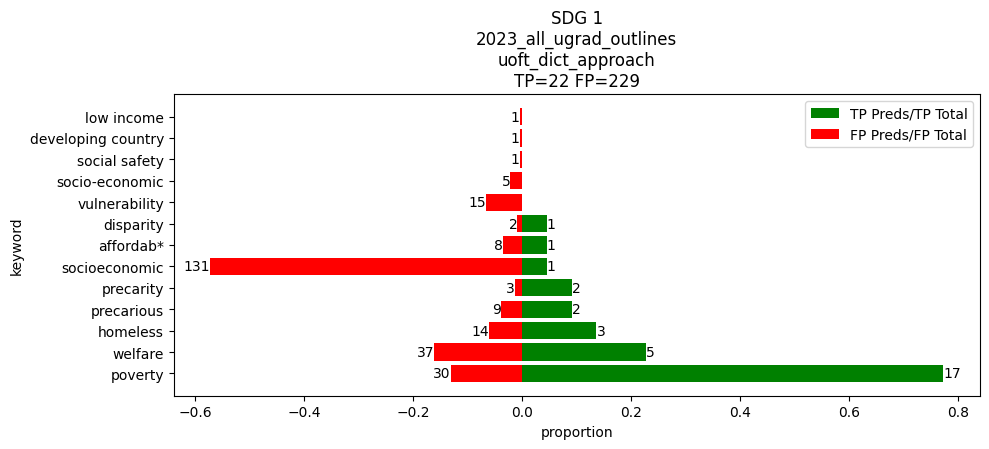

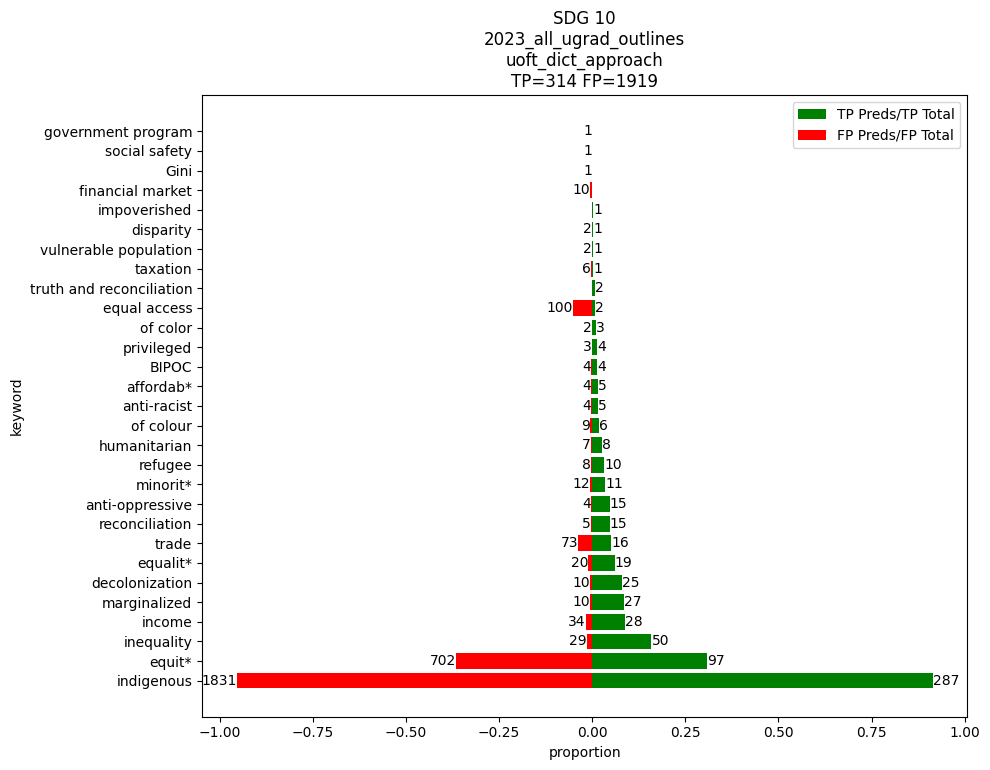

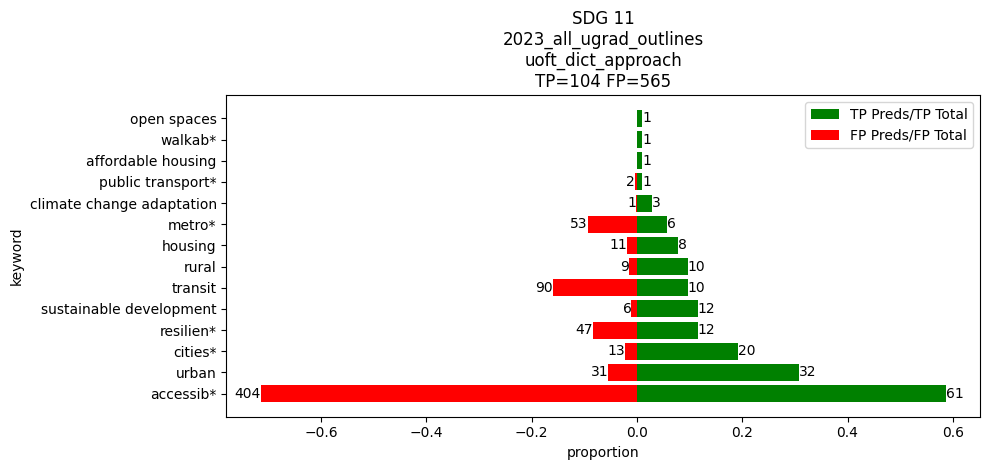

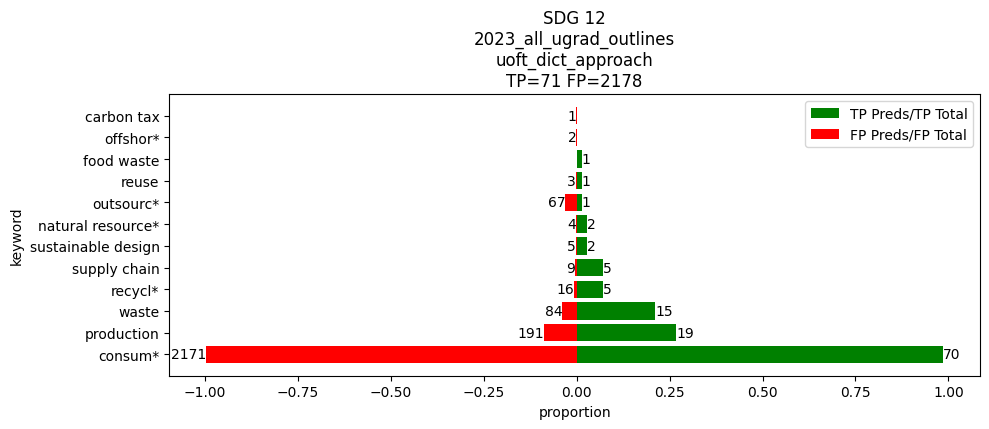

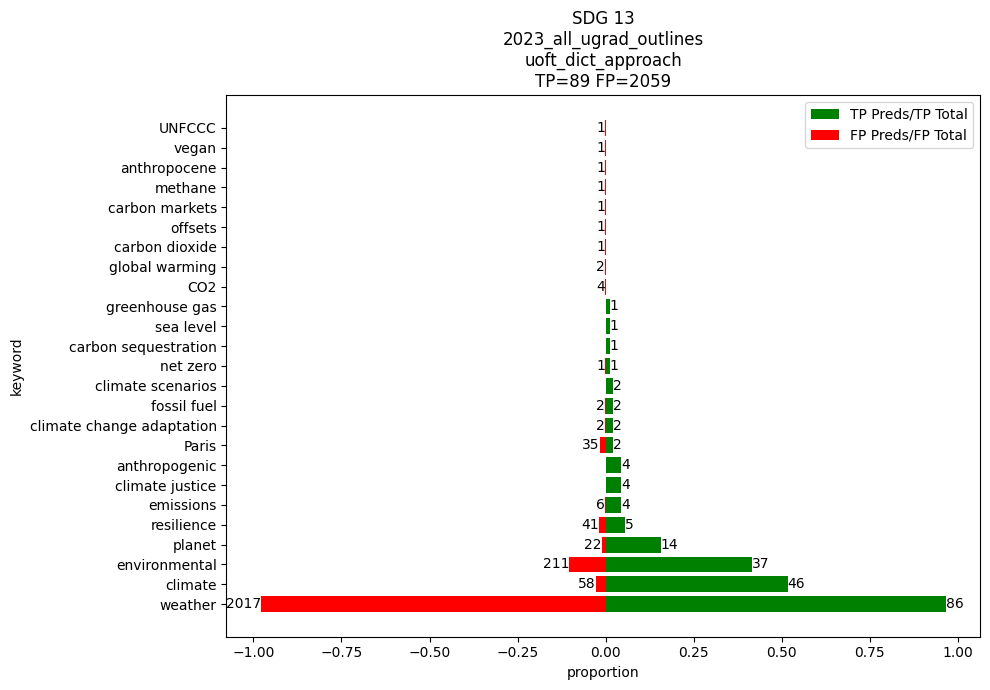

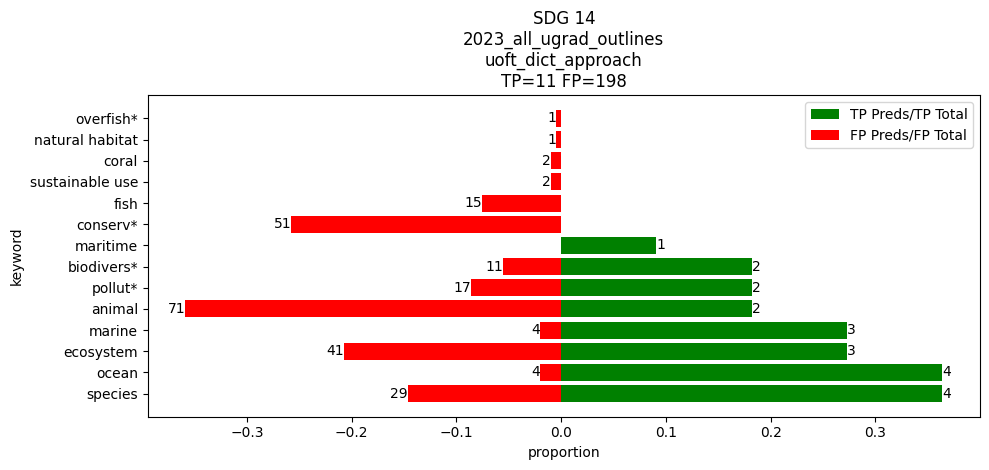

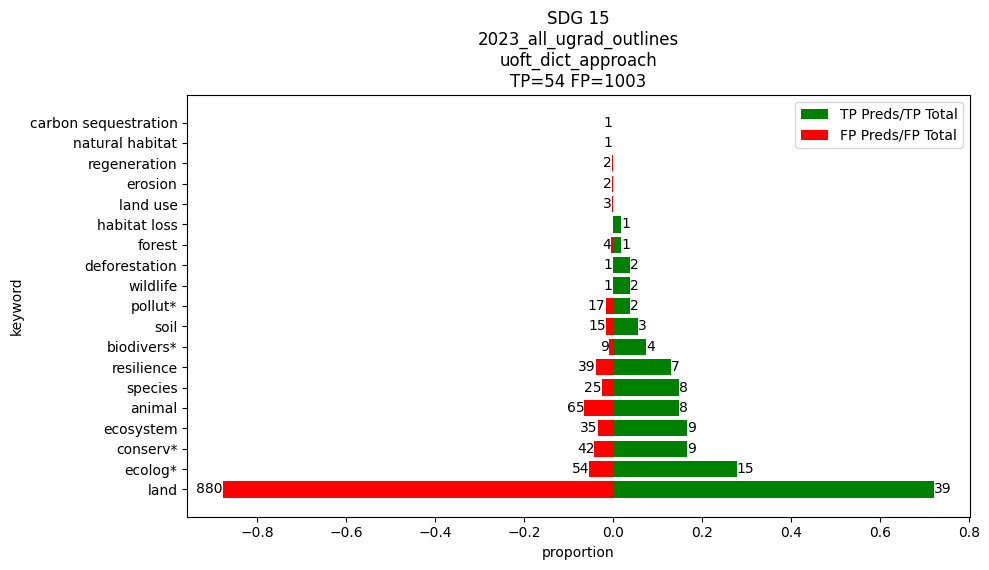

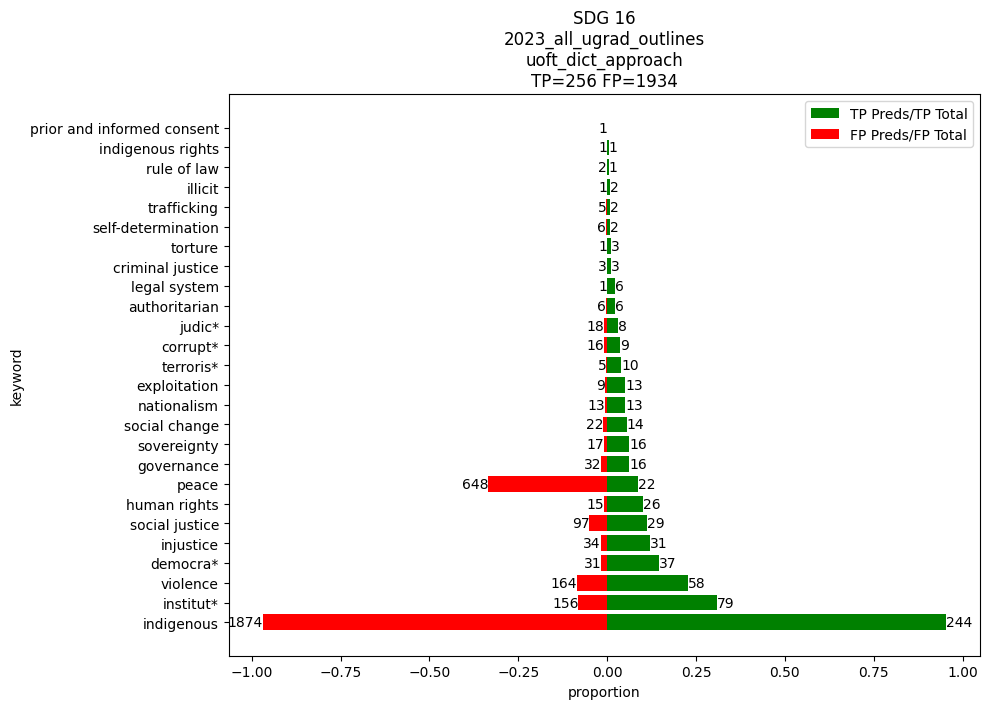

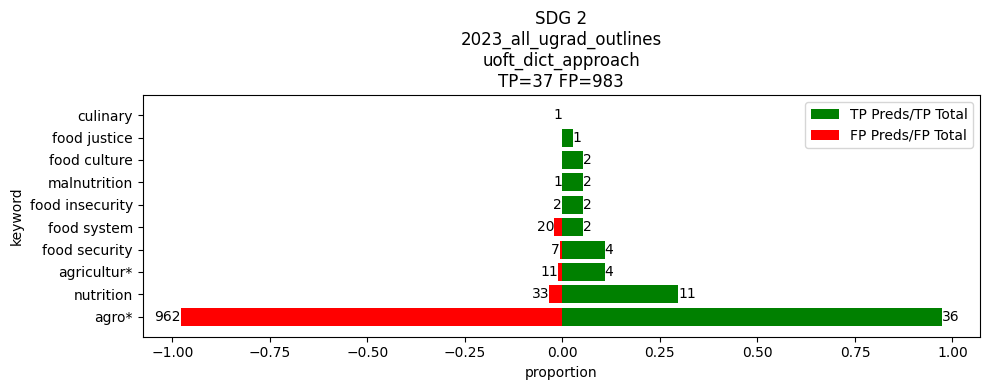

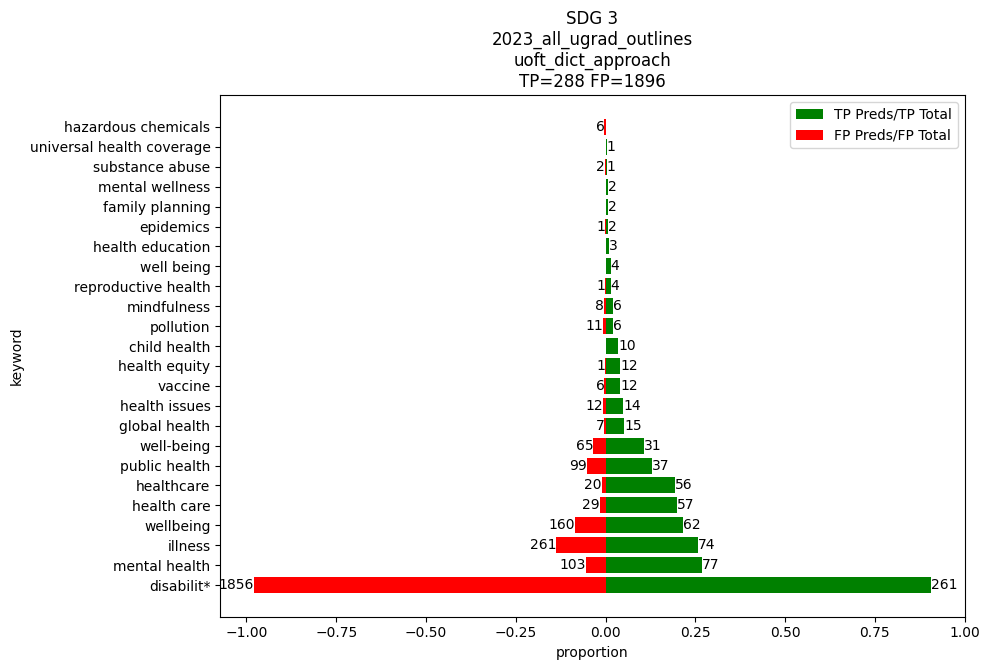

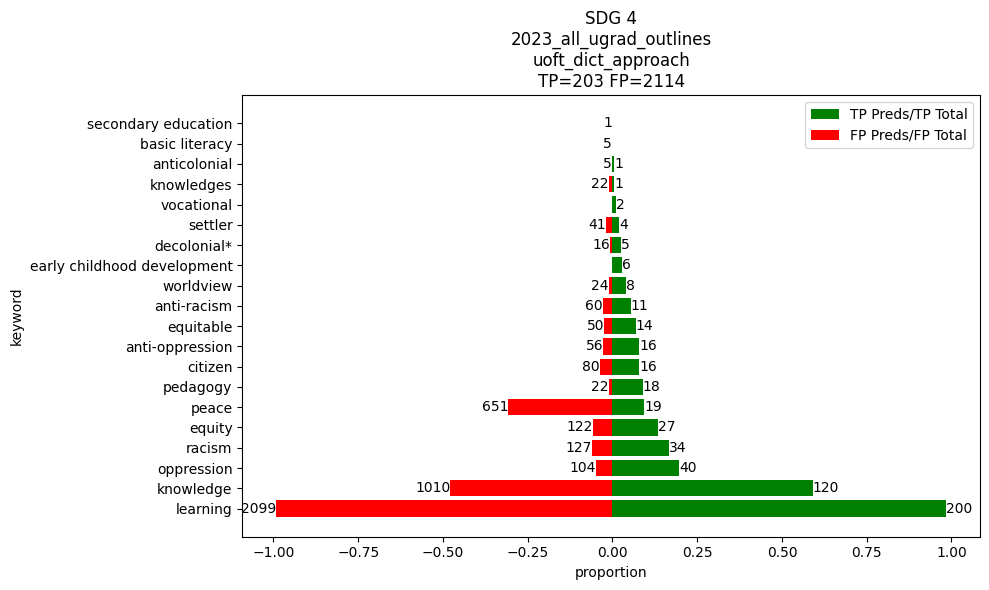

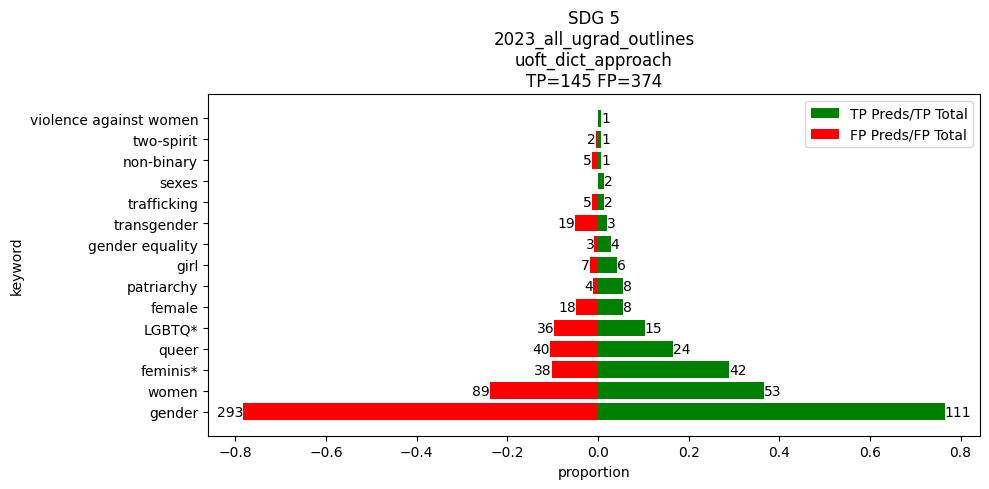

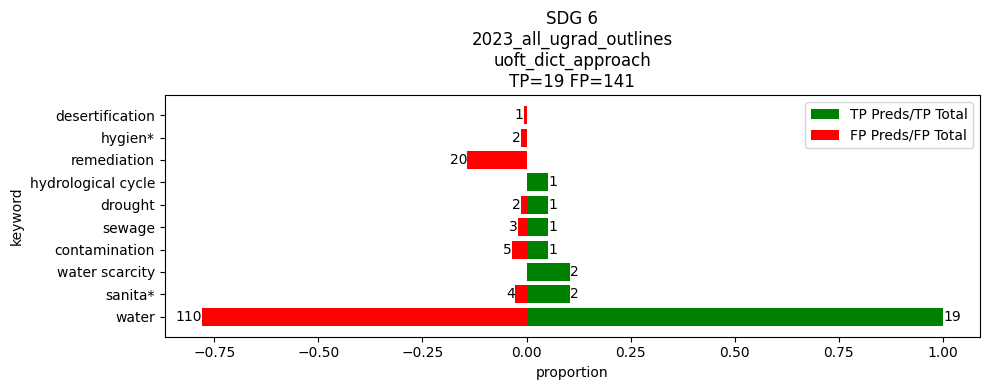

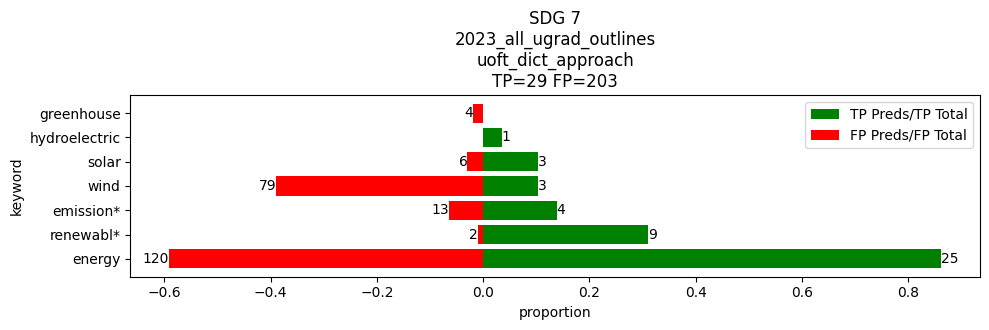

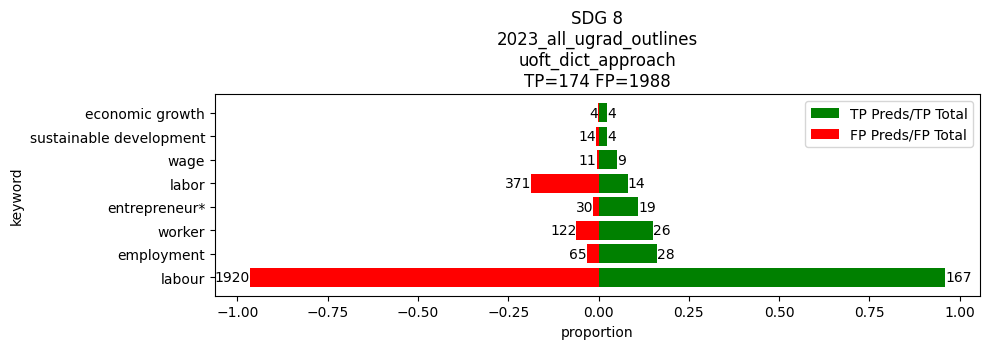

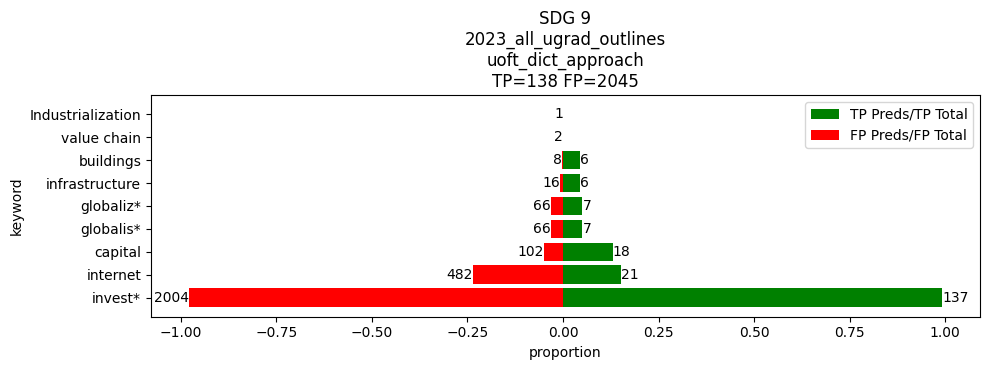

In [5]:
for cols, group in df[df["datatype"] == "raw"].groupby(groupbycols):
    groupbydict = dict(zip(groupbycols, cols))

    topbot_5 = group.sort_values(
        ["TP_proportion", "FP_proportion"], ascending=[False, True]
    )

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 2 + 0.2 * group.shape[0]))

    # Plot positive values horizontally
    ax.barh(
        topbot_5["keyword"],
        topbot_5["TP_proportion"],
        color="green",
        label="TP Preds/TP Total",
    )

    # Plot negative values horizontally
    ax.barh(
        topbot_5["keyword"],
        topbot_5["FP_proportion"],
        color="red",
        label="FP Preds/FP Total",
    )

    # Set labels for each bar
    for i, (tp_total, tp, fp_total, fp) in enumerate(
        zip(topbot_5["TP_total"], topbot_5["TP"], topbot_5["FP_total"], topbot_5["FP"])
    ):
        tp_prop = topbot_5["TP_proportion"].iloc[i]
        if tp_prop != 0:
            ax.text(
                tp_prop,
                topbot_5["keyword"].iloc[i],
                f"{tp}",
                va="center",
                ha="left",
            )

        fp_prop = topbot_5["FP_proportion"].iloc[i]
        if fp_prop != 0:
            ax.text(
                fp_prop,
                topbot_5["keyword"].iloc[i],
                f"{fp}",
                va="center",
                ha="right",
            )

    # Set axis labels and title
    ax.set_xlabel("proportion")
    ax.set_ylabel("keyword")
    ax.set_title(
        f"{groupbydict['sdg']}\n{groupbydict['project_name']}\n{groupbydict['model_name']}\nTP={tp_total} FP={fp_total}"
    )

    # Show legend
    ax.legend()

    # Show the plot
    fig.tight_layout()
    plt.show()

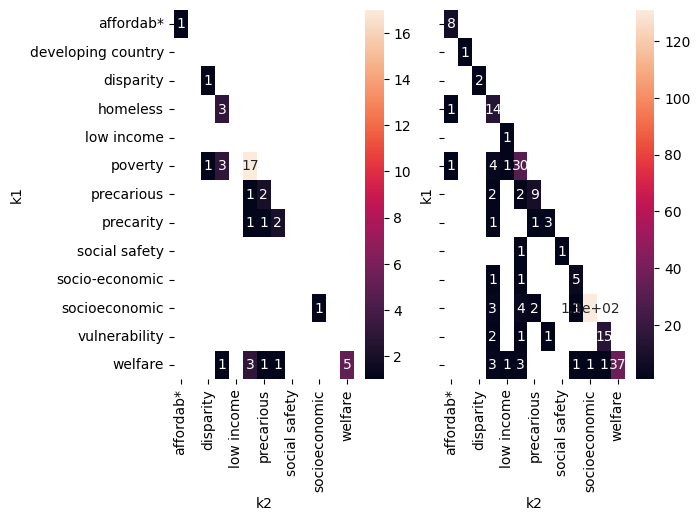

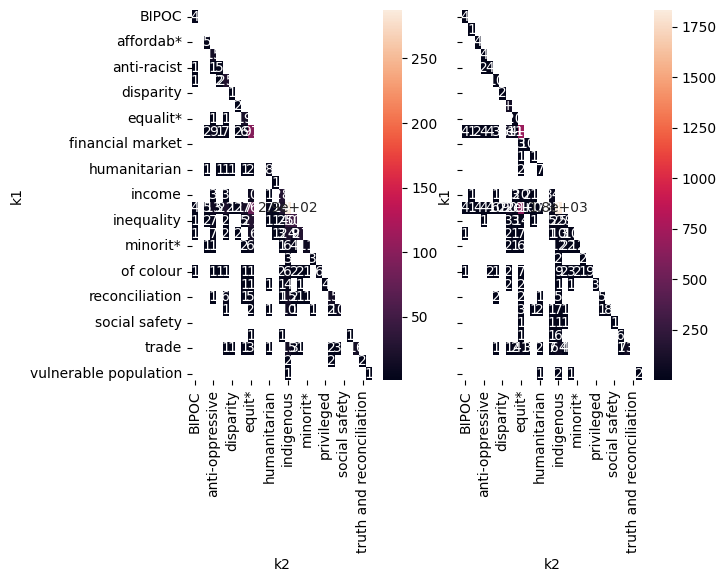

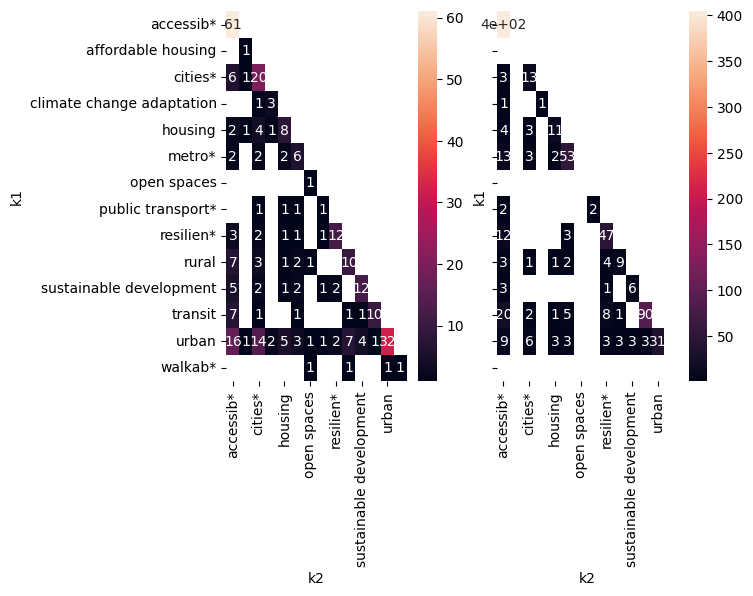

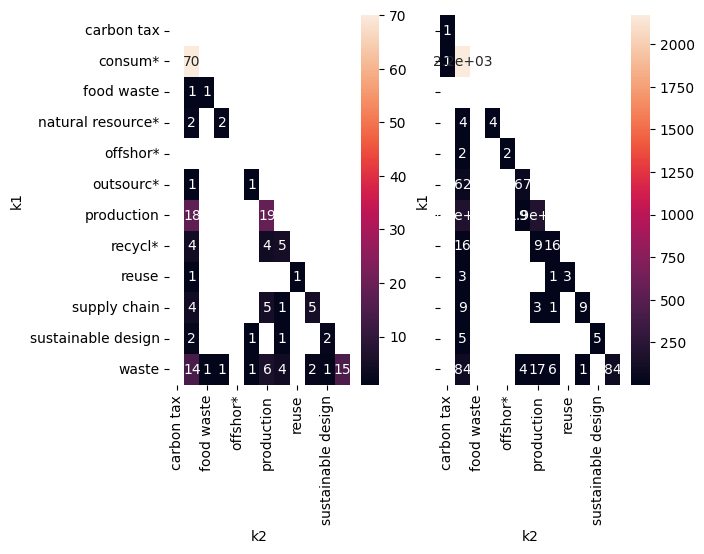

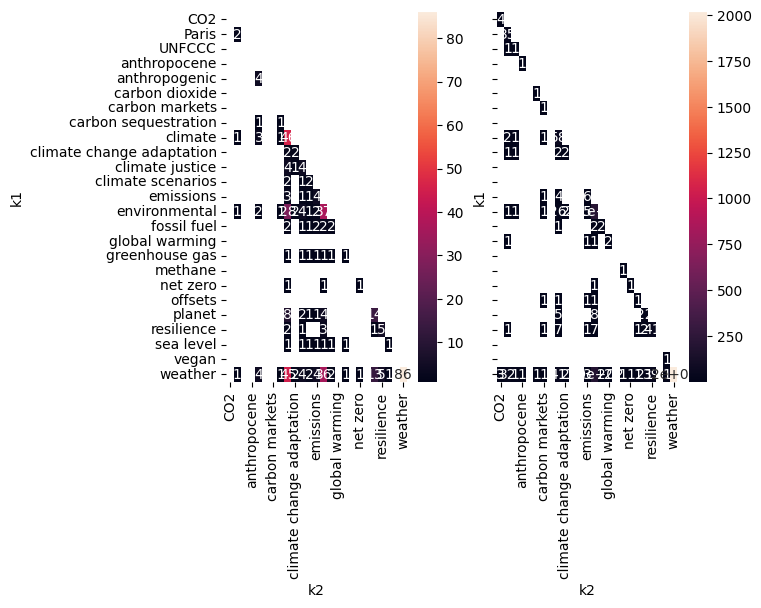

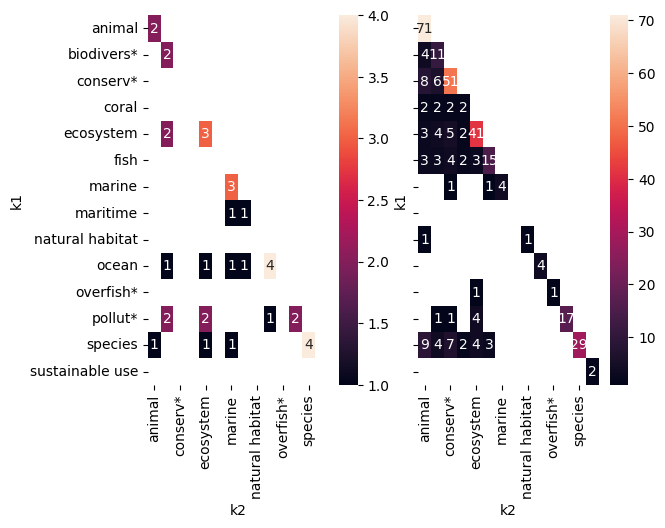

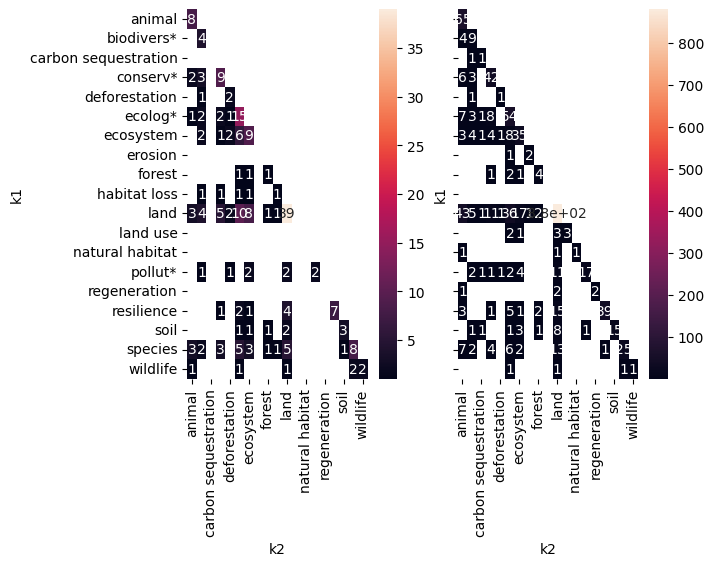

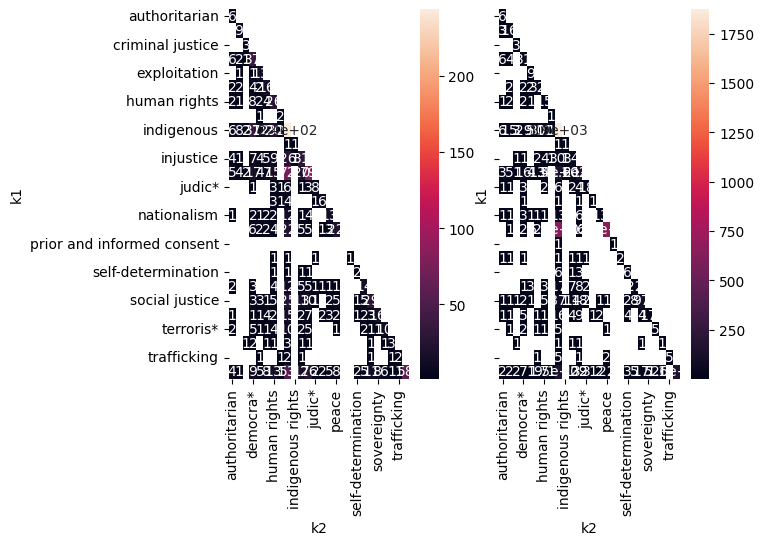

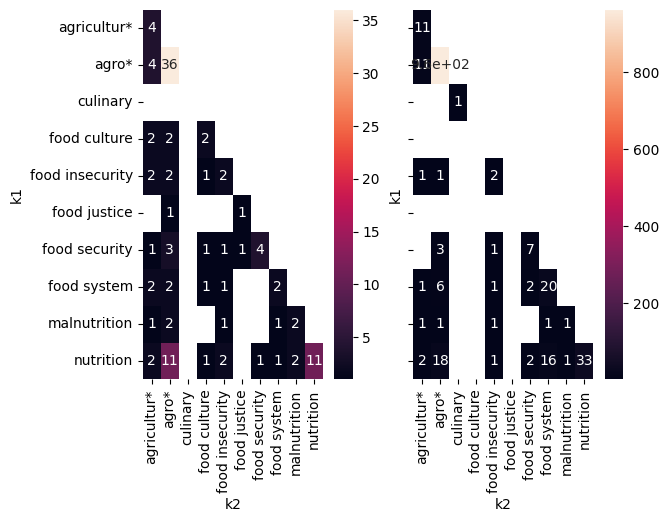

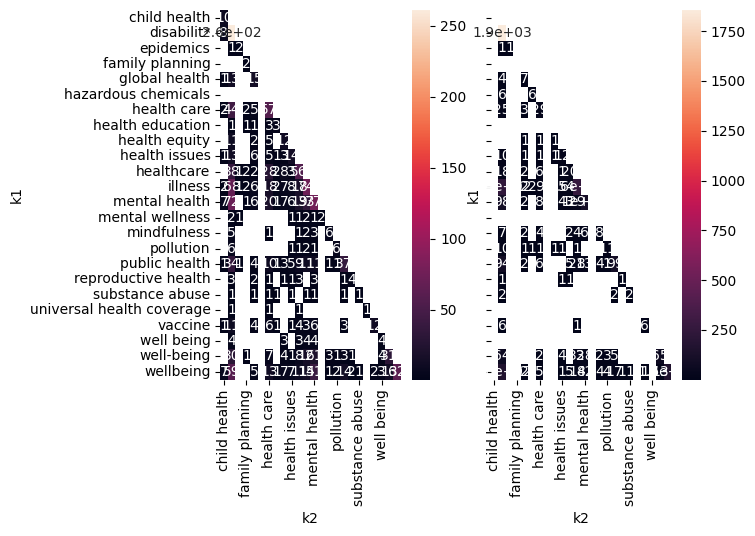

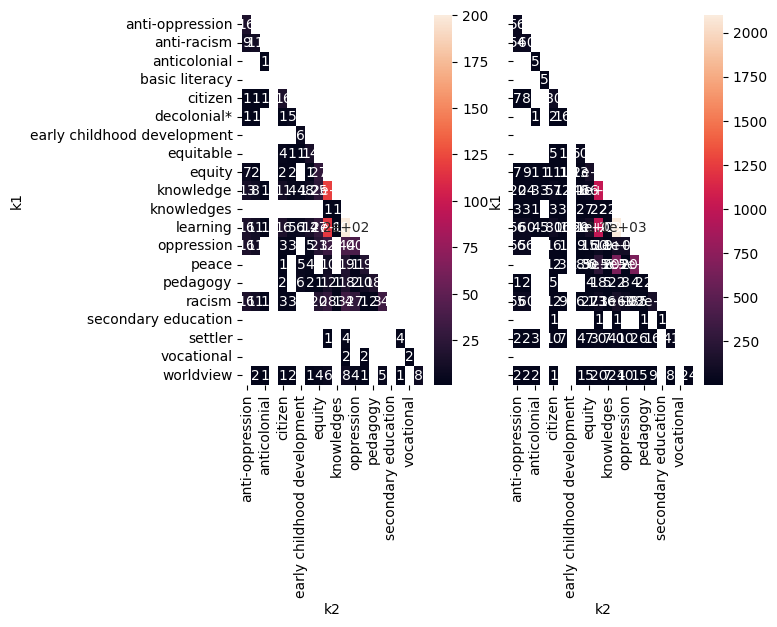

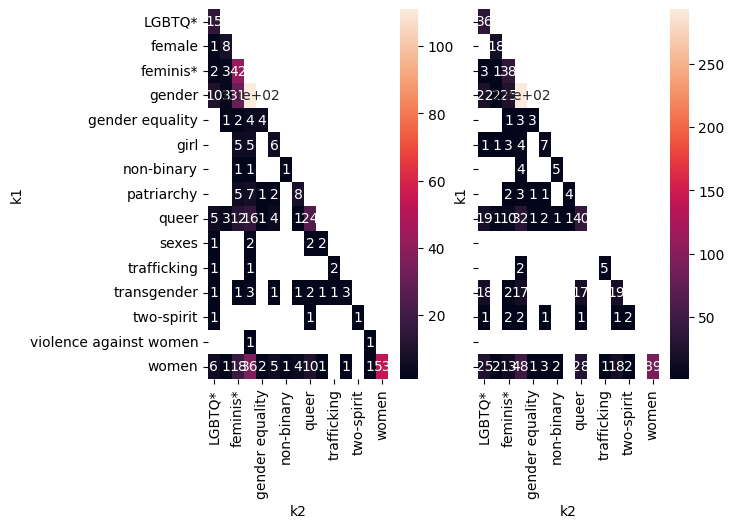

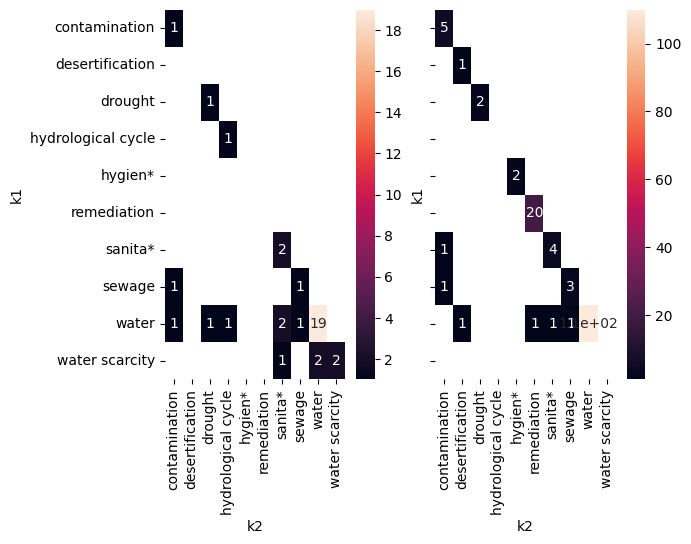

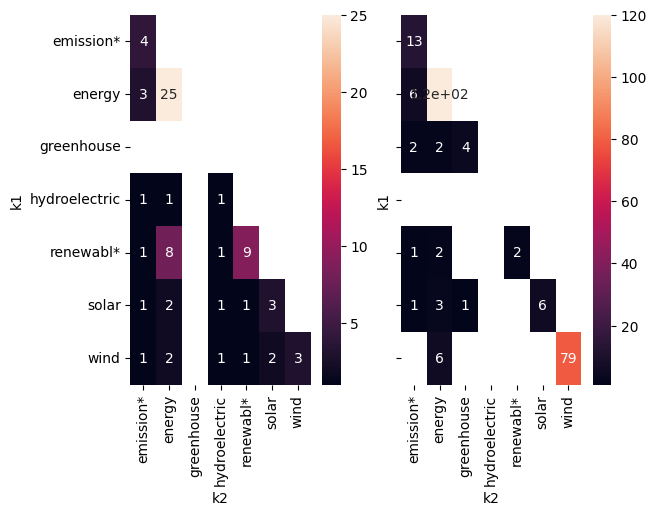

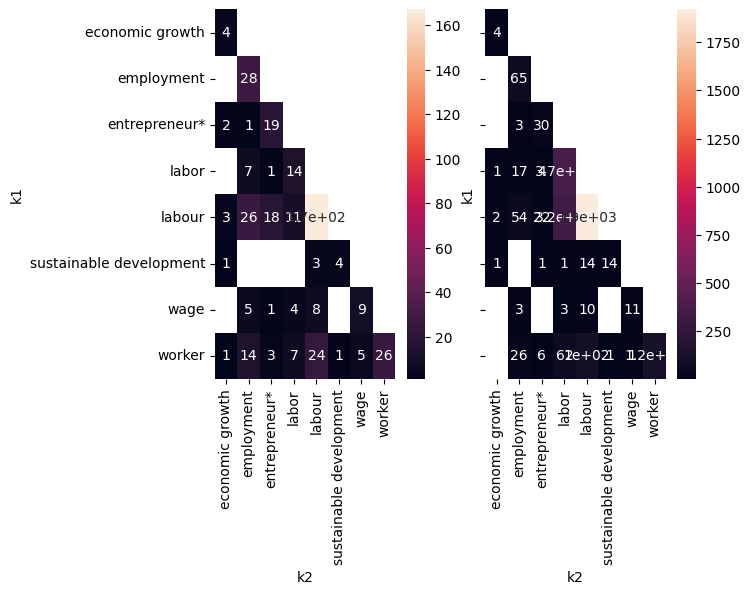

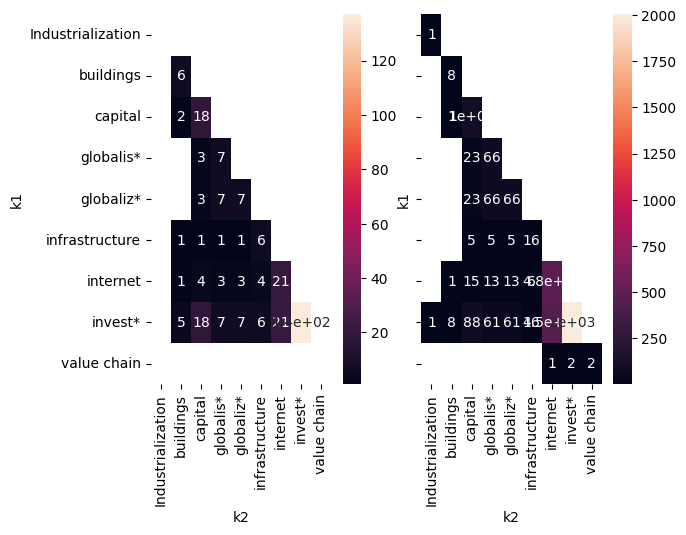

In [6]:
def melt_table(group):
    out = []
    for i1, k1 in enumerate(group["keyword"]):
        for i2, k2 in enumerate(group["keyword"]):
            out.append(
                dict(
                    k1=k1,
                    k2=k2,
                    TP_overlap=len(
                        group.iloc[i1]["TP_indicies"].intersection(
                            group.iloc[i2]["TP_indicies"]
                        )
                    ),
                    FP_overlap=len(
                        group.iloc[i1]["FP_indicies"].intersection(
                            group.iloc[i2]["FP_indicies"]
                        )
                    ),
                )
            )
    return pd.DataFrame(out)


# Create a matrix of overlaps
for cols, group in df[df["datatype"] == "raw"].groupby(groupbycols):
    fig, axs = plt.subplots(ncols=2, sharey=True)
    groupbydict = dict(zip(groupbycols, cols))

    melt = melt_table(group)
    pivot_table1 = melt.pivot_table(index="k1", columns="k2", values="TP_overlap")
    pivot_table1 = pivot_table1.replace(0, np.nan)
    pivot_table2 = melt.pivot_table(index="k1", columns="k2", values="FP_overlap")
    pivot_table2 = pivot_table2.replace(0, np.nan)
    mask = np.triu(np.ones_like(pivot_table1, dtype=bool), k=1)

    sns.heatmap(pivot_table1, annot=True, mask=mask, ax=axs[0])
    sns.heatmap(pivot_table2, annot=True, mask=mask, ax=axs[1])

    plt.show()

In [7]:
sdgs = list(df["sdg"].unique().tolist())
model_names = list(df["model_name"].unique().tolist())
project_names = list(df["project_name"].unique().tolist())
datatypes = list(df["datatype"].unique().tolist())

if df["FP_proportion"].iloc[0] < 0:
    df["FP_proportion"] = df["FP_proportion"].apply(lambda x: -x)
trace1 = px.scatter(
    df,
    x="TP_proportion",
    y="FP_proportion",
    custom_data=[
        "keyword",
        "TP",
        "FP",
        "TP_unique_count",
        "FP_unique_count",
        "datatype",
    ],
    size="TP_unique_count",
    color="FP_unique_count",
)
trace1.update_traces(
    hovertemplate="<br>".join(
        [
            "ColX: %{x}",
            "ColY: %{y}",
            "keyword: %{customdata[0]}",
            "TP: %{customdata[1]}",
            "FP: %{customdata[2]}",
            "TP_unique_count: %{customdata[3]}",
            "FP_unique_count: %{customdata[4]}",
            "datatype: %{customdata[5]}",
        ]
    )
)
fig = go.FigureWidget(trace1)
fig.add_shape(
    type="line",
    x0=0,
    y0=0,
    x1=1,
    y1=1,
    line=dict(
        color="Red",
    ),
    xref="x",
    yref="y",
)

sdgDrop = widgets.Dropdown(
    description="SDG:",
    value=sdgs[0],
    options=sdgs,
)
modelDrop = widgets.Dropdown(
    description="Model name:",
    value=model_names[0],
    options=model_names,
)
projectDrop = widgets.Dropdown(
    description="Project name:",
    value=project_names[0],
    options=project_names,
)
datatypeDrop = widgets.Dropdown(
    description="Datatype:",
    value=datatypes[0],
    options=datatypes,
)


# This will be called when the filter dropdown changes.
def filterResponse(change):
    # generate the new traces that are filtered by teamname, season, or player
    filtered_data = df[
        (df["sdg"] == sdgDrop.value)
        & (df["model_name"] == modelDrop.value)
        & (df["project_name"] == projectDrop.value)
        & (df["datatype"] == datatypeDrop.value)
    ]

    tempTrace = go.Scatter(
        x=filtered_data["TP_proportion"],
        y=filtered_data["FP_proportion"],
        customdata=filtered_data[
            [
                "keyword",
                "TP",
                "FP",
                "TP_unique_count",
                "FP_unique_count",
                "datatype",
            ]
        ],
        mode="markers",
        marker_color=filtered_data["FP_unique_count"],
        marker_size=filtered_data["TP_unique_count"] + 10,
        hovertemplate="<br>".join(
            [
                "ColX: %{x}",
                "ColY: %{y}",
                "keyword: %{customdata[0]}",
                "TP: %{customdata[1]}",
                "FP: %{customdata[2]}",
                "TP_unique_count: %{customdata[3]}",
                "FP_unique_count: %{customdata[4]}",
                "datatype: %{customdata[5]}",
            ]
        ),
    )

    with fig.batch_update():
        # Delete the old traces and add the new traces in one at a time
        fig.data = []
        fig.add_trace(tempTrace)


# These determine what function should be called when a drop down changes
sdgDrop.observe(filterResponse, names="value")
modelDrop.observe(filterResponse, names="value")
projectDrop.observe(filterResponse, names="value")
datatypeDrop.observe(filterResponse, names="value")

# HBox and VBox are used to organize the other widgets and figures
container = widgets.HBox([sdgDrop, modelDrop, projectDrop, datatypeDrop])
widgets.VBox([container, fig])

In [8]:
sdgs = list(df["sdg"].unique().tolist())
model_names = list(df["model_name"].unique().tolist())
project_names = list(df["project_name"].unique().tolist())
datatypes = list(df["datatype"].unique().tolist())

trace1 = px.scatter(
    df,
    x="recall",
    y="precision_all",
    custom_data=[
        "keyword",
        "TP",
        "FP",
        "recall",
        "precision_all",
        "precision_kw",
        "datatype",
    ],
)
trace1.update_traces(
    hovertemplate="<br>".join(
        [
            "ColX: %{x}",
            "ColY: %{y}",
            "keyword: %{customdata[0]}",
            "TP: %{customdata[1]}",
            "FP: %{customdata[2]}",
            "recall: %{customdata[3]}",
            "precision_all: %{customdata[4]}",
            "precision_kw: %{customdata[5]}",
            "datatype: %{customdata[6]}",
        ]
    )
)
fig = go.FigureWidget(trace1)
fig.add_shape(
    type="line",
    x0=0,
    y0=0,
    x1=1,
    y1=1,
    line=dict(
        color="Red",
    ),
    xref="x",
    yref="y",
)

sdgDrop = widgets.Dropdown(
    description="SDG:",
    value=sdgs[0],
    options=sdgs,
)
modelDrop = widgets.Dropdown(
    description="Model name:",
    value=model_names[0],
    options=model_names,
)
projectDrop = widgets.Dropdown(
    description="Project name:",
    value=project_names[0],
    options=project_names,
)
datatypeDrop = widgets.Dropdown(
    description="Datatype:",
    value=datatypes[0],
    options=datatypes,
)


# This will be called when the filter dropdown changes.
def filterResponse(change):
    # generate the new traces that are filtered by teamname, season, or player
    filtered_data = df[
        (df["sdg"] == sdgDrop.value)
        & (df["model_name"] == modelDrop.value)
        & (df["project_name"] == projectDrop.value)
        & (df["datatype"] == datatypeDrop.value)
    ]

    tempTrace = go.Scatter(
        x=filtered_data["recall"],
        y=filtered_data["precision_all"],
        customdata=filtered_data[
            [
                "keyword",
                "TP",
                "FP",
                "recall",
                "precision_all",
                "precision_kw",
                "datatype",
            ]
        ],
        mode="markers",
        hovertemplate="<br>".join(
            [
                "ColX: %{x}",
                "ColY: %{y}",
                "keyword: %{customdata[0]}",
                "TP: %{customdata[1]}",
                "FP: %{customdata[2]}",
                "recall: %{customdata[3]}",
                "precision_all: %{customdata[4]}",
                "precision_kw: %{customdata[5]}",
                "datatype: %{customdata[6]}",
            ]
        ),
    )

    with fig.batch_update():
        # Delete the old traces and add the new traces in one at a time
        fig.data = []
        fig.add_trace(tempTrace)


# These determine what function should be called when a drop down changes
sdgDrop.observe(filterResponse, names="value")
modelDrop.observe(filterResponse, names="value")
projectDrop.observe(filterResponse, names="value")
datatypeDrop.observe(filterResponse, names="value")

# HBox and VBox are used to organize the other widgets and figures
container = widgets.HBox([sdgDrop, modelDrop, projectDrop, datatypeDrop])
widgets.VBox([container, fig])